In [4]:
from torch.utils.data import DataLoader
from timm.optim import create_optimizer_v2
from swa_orchestrator import SWAorchestrator
from models import LSTM, STGCN, GCN_LSTM
from utils import *

#   local   #
dir_path = ''

pemsbay = 'PEMS-BAY'
pemsbay_kag = "scchuy/pemsbay"
pemsbay_pkl = 'adj_mx_bay.pkl'
pemsbay_h5 = 'pems-bay.h5'

loss_name = 'Huber'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data_graph_dict = load_and_preprocess(pemsbay, pemsbay_kag, pemsbay_pkl, pemsbay_h5, key='speed')
data_dict, graph_dict = data_graph_dict['data'], data_graph_dict['graph']

100%|██████████| 29.9M/29.9M [00:02<00:00, 10.9MB/s]

Extracting files...


PEMS-BAY graph loaded with 325 sensors
Data aggregated into 5min intervals
Imputing missing values
Implementing a 70%-10%-20% split


In [6]:
window_dict = {}

for key, val in data_dict.items():
    if isinstance(val, np.ndarray):
        window_dict[key] = make_windows(val)

In [7]:
X_train, y_train = window_dict['train']['X'], window_dict['train']['y']
X_val, y_val = window_dict['val']['X'], window_dict['val']['y']
X_test, y_test = window_dict['test']['X'], window_dict['test']['y']

X_train.shape

(36475, 12, 325)

In [8]:
batch_size = 64

train_loader = DataLoader(TrafficDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val, y_val), batch_size=batch_size)
test_loader  = DataLoader(TrafficDataset(X_test,  y_test), batch_size=batch_size)

In [13]:
num_sensors = len(graph_dict['sensors'])
max_epochs = 250

configs = {

    'STGCN': {
        'class': STGCN,
        'params': {
            'adj_matrix': graph_dict['adj_matrix'],
            'input_size': 1,
            'hidden_size': 64,
            'gcn_channels': 16,
            'num_layers': 2,
            'horizon': 3,
            'output_size': 1,
            'dropout': 0.1
        },
        'lr': .01,
        'warmup_t': 10,
        't_initial': 50
    },

    'GCN-LSTM': {
        'class' : GCN_LSTM,
        'params' : {
            'adj_matrix': graph_dict['adj_matrix'],
            'input_size': 1,
            'gcn_channels': 16,
            'gcn_out': 16,
            'lstm_hidden': 64,
            'node_embed_dim': 16,
            'num_layers': 1,
            'horizon': 3,
            'output_size': 1,
            'spatial_layers': 2,
            'dropout': 0.1
        },
        'lr': 3.5e-3,
        'warmup_t': 20,
        't_initial': 20
    },

    'LSTM': {
        'class': LSTM,
        'params': {
            'input_size': num_sensors,
            'hidden_size': 64,
            'num_layers': 3,
            'horizon': 3,
            'output_size': num_sensors,
            'dropout': 0.1
        },
        'lr': .1,
        'warmup_t': 15,
        't_initial': 50
    },
}

In [14]:
criterion = nn.HuberLoss() if loss_name == 'Huber' else nn.MSELoss()

encyclopedia = {}
metrics = []

for name, conf in configs.items():
    model = conf['class'](**conf['params']).to(device)

    optimizer = create_optimizer_v2(
        model,
        opt='sgd',
        lr=conf['lr'],
        momentum=0.9,
        weight_decay=1e-4,
        filter_bias_and_bn=True
    )

    orchestrator = SWAorchestrator(
        model,
        optimizer=optimizer,
        warmup_t=conf['warmup_t'],
        t_initial=conf['t_initial']
      )

    encyclopedia[name] = {}

    history = train_model(
        model_name = name,
        epochs = max_epochs,
        criterion = criterion,
        optimizer = optimizer,
        scheduler = orchestrator,
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        device = device
    )

    encyclopedia[name]['history'] = history

    swa_model = orchestrator.swa_model
    encyclopedia[name]['swa_model'] = swa_model

    _, preds_inv, targets_inv = evaluate(criterion, test_loader, swa_model, device, scaler=data_dict['scaler'])

    encyclopedia[name]['preds'] = preds_inv
    encyclopedia[name]['labels'] = targets_inv

    metrics.append(get_metrics(name, preds_inv, targets_inv))

    del model, optimizer, orchestrator
    torch.cuda.empty_cache()

Training the STGCN
Epoch 1 [SGD] | Loss: 0.4767 | Val loss: 0.5497
> New best model
Epoch 2 [SGD] | Loss: 0.4722 | Val loss: 0.5444
> New best model
Epoch 3 [SGD] | Loss: 0.0783 | Val loss: 0.0759
> New best model
Epoch 4 [SGD] | Loss: 0.0620 | Val loss: 0.0737
> New best model
Epoch 5 [SGD] | Loss: 0.0597 | Val loss: 0.0704
> New best model
Epoch 6 [SGD] | Loss: 0.0559 | Val loss: 0.0639
> New best model
Epoch 7 [SGD] | Loss: 0.0526 | Val loss: 0.0620
> New best model
Epoch 8 [SGD] | Loss: 0.0508 | Val loss: 0.0598
> New best model
Epoch 9 [SGD] | Loss: 0.0495 | Val loss: 0.0584
> New best model
Epoch 10 [SGD] | Loss: 0.0486 | Val loss: 0.0575
> New best model
Epoch 11 [SGD] | Loss: 0.0479 | Val loss: 0.0570
> New best model
Epoch 12 [SGD] | Loss: 0.0475 | Val loss: 0.0566
> New best model
Epoch 13 [SGD] | Loss: 0.0469 | Val loss: 0.0557
> New best model
Epoch 14 [SGD] | Loss: 0.0463 | Val loss: 0.0551
> New best model
Epoch 15 [SGD] | Loss: 0.0459 | Val loss: 0.0548
> New best model


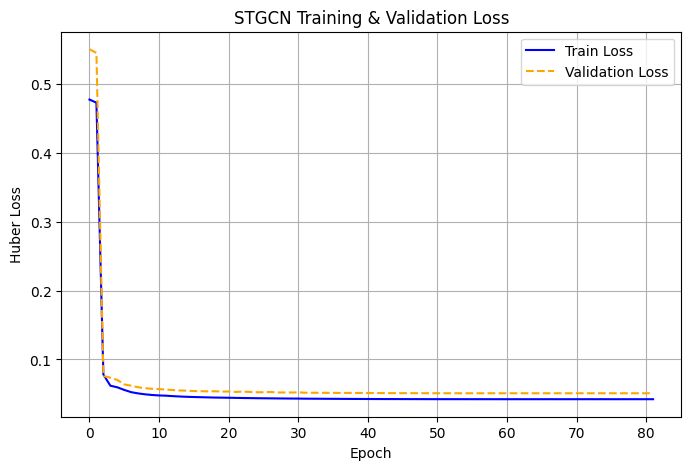

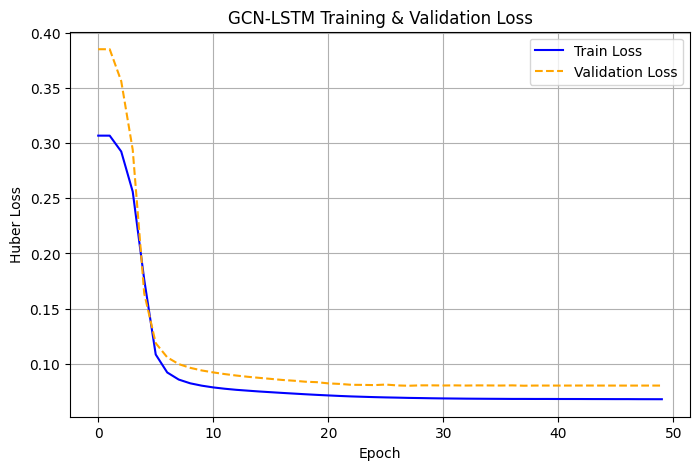

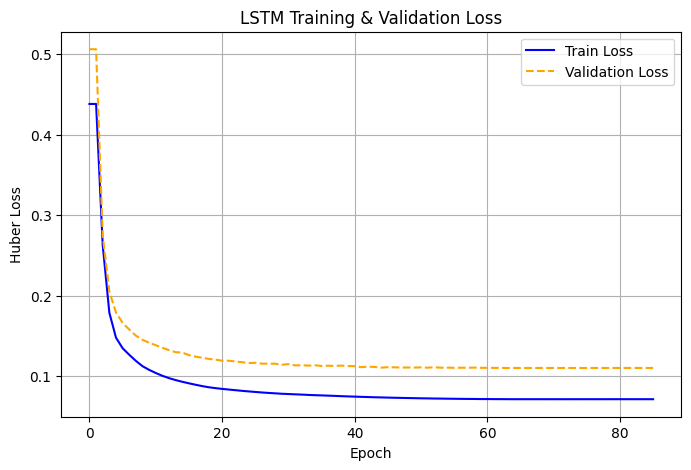

In [15]:
for name in encyclopedia.keys():
    history = encyclopedia[name]['history']
    plot_training_history(pemsbay, name, history, loss_name + ' Loss', dir_path)

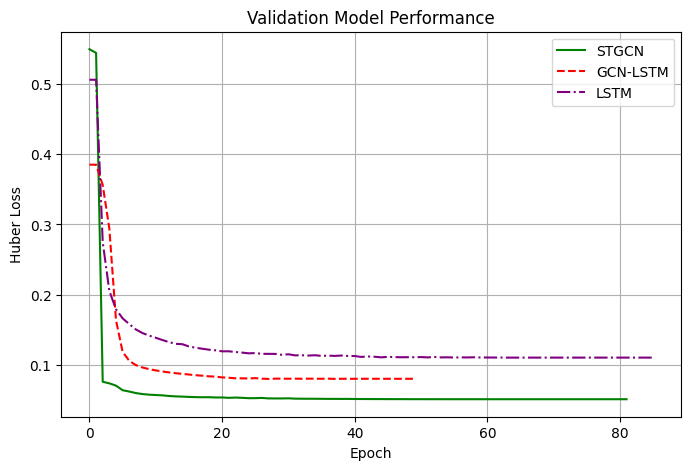

In [16]:
plt.figure(figsize=(8,5))

colors = ['green', 'red', 'purple']
line_styles = ['-', '--', '-.']

for i, name in enumerate(encyclopedia.keys()):
  val_history = encyclopedia[name]['history']['val']
  plt.plot(val_history, label=name, color=colors[i], linestyle=line_styles[i])

plt.xlabel('Epoch')
plt.ylabel(loss_name + ' Loss')
plt.title('Validation Model Performance')
plt.legend()
plt.grid(True)
plt.show()

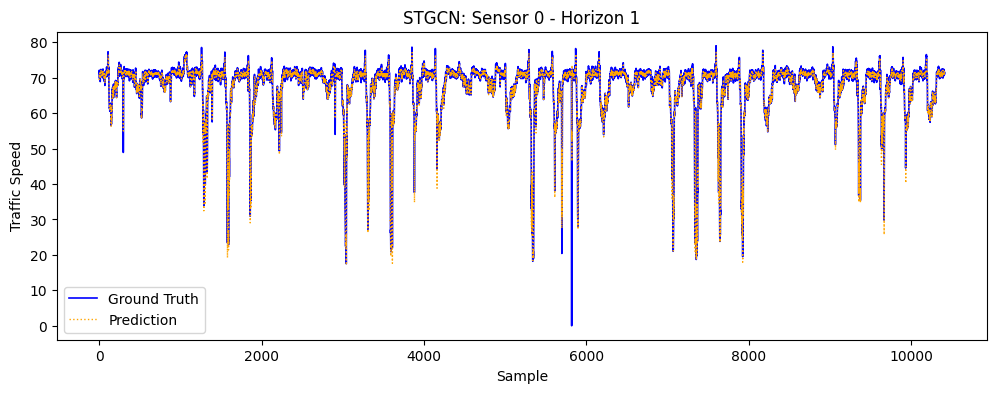

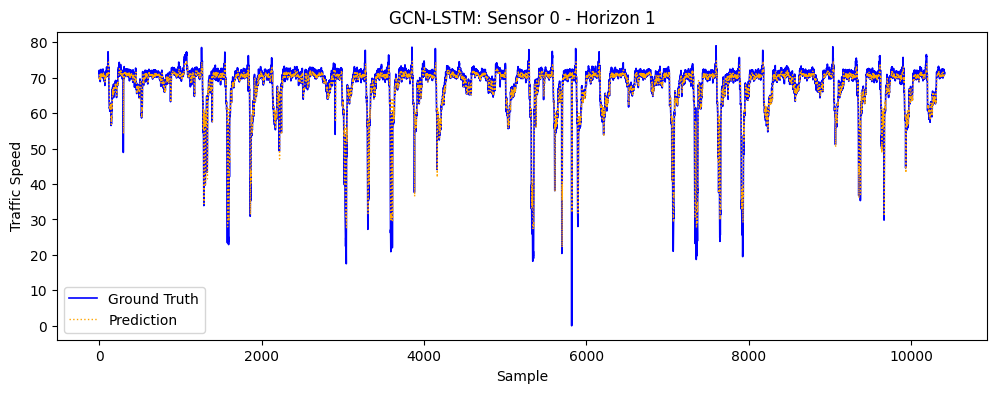

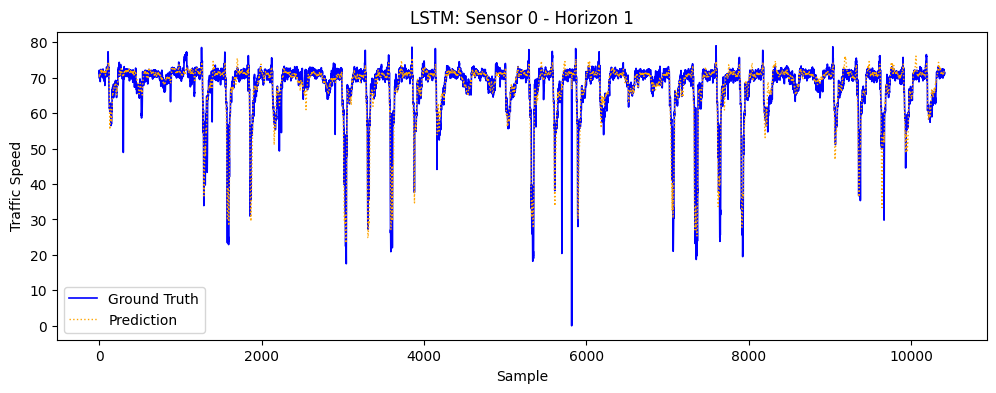

In [17]:
for name in encyclopedia.keys():
    preds = encyclopedia[name]['preds']
    labels = encyclopedia[name]['labels']

    plot_sample(name, 0, 0, preds, labels, dir_path)

In [18]:
metrics_df = pd.concat(metrics, axis=1)
metrics_df.round(4)

,STGCN,GCN-LSTM,LSTM
MSE,6.8599,11.5989,19.6371
MAE,1.2948,1.6564,2.3368
WAPE,2.0729,2.6517,3.7409
